In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn
import os
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve

random.seed(12)
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### Particle-Mesh Method

In [2]:
class ParMesh:

    def __init__(self, Ng, particle, x, T, dt):
        # Np:粒子数量
        # Ng:每一维度网格划分数量
        # particle (List of [Np, 7]) 点粒子状态 ; index分别为[x, y, z, vx, vy, vz, m] m为粒子质量
        # T: 积分总计时间
        # dt:每一步积分步长
        self.Np = len(particle)
        self.Ng = Ng
        self.particle = particle
        self.x = x                              # 模拟的空间尺度大小
        self.dx = x / Ng                          # 每一个网格对应的空间大小
        self.T = T                              # 待积分的总时间
        self.t = 0                              # 目前演化的时间
        self.dt = dt
        self.dens = np.zeros((Ng, Ng, Ng))      # 质量密度
        self.phi = np.zeros((Ng, Ng, Ng))       # 引力势phi
        self.acc = np.zeros((3, Ng, Ng, Ng))    # 格点加速度场
        self.acc1 = np.zeros((3, Ng, Ng, Ng))    # 格点加速度场

        # 波数坐标网格
        k = np.fft.fftfreq(self.Ng, d=self.dx)
        kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
        k_squared = kx**2 + ky**2 + kz**2
        k_squared[0, 0, 0] = 1
        self.kcoeff = k_squared
    
    def Par2dens(self):
        # 通过particle计算密度场分布

        dens = np.zeros( (self.Ng, self.Ng, self.Ng) )
        for i in range(self.Np):
            spar = self.particle[i]
            par_m = spar[6]
            par_i = spar[:3] / self.dx
            # 计算粒子左下角的网格点索引
            par_ix, par_iy, par_iz = np.floor(par_i - 0.5).astype(int)
            # 计算相对于左下角格点的粒子位置
            par_isx, par_isy, par_isz = par_i - 0.5 - [par_ix, par_iy, par_iz]
            # 将粒子质量摊分到网格上
            for di in range(2):
                for dj in range(2):
                    for dk in range(2):
                        weight = (1 - np.abs(di - par_isx)) * (1 - np.abs(dj - par_isy)) * (1 - np.abs(dk - par_isz))
                        dens[(par_ix + di) % self.Ng, (par_iy + dj) % self.Ng, (par_iz + dk) % self.Ng] += par_m * weight
        self.dens = dens
        return

    def dens2phi(self):
        
        # 通过密度场通过FFT方法计算引力势phi
        rho_k = fftn(self.dens)
        phi_k = - 4 * np.pi * rho_k * G / self.kcoeff
        phi_k[0, 0, 0] = 0
        phi = ifftn(phi_k)
        phi = np.real(phi)
        self.phi = phi
        return

    def phi2acc(self):
        # 通过引力势还原到格点加速度

        acc = np.zeros((3, self.Ng, self.Ng, self.Ng))
        # 分别代表x,y,z三个方向的加速度分量，采取周期边界条件
        acc[0, :, :, :] = (np.roll(self.phi, 1, axis=0) - np.roll(self.phi, -1, axis=0)) / 2
        acc[1, :, :, :] = (np.roll(self.phi, 1, axis=1) - np.roll(self.phi, -1, axis=1)) / 2
        acc[2, :, :, :] = (np.roll(self.phi, 1, axis=2) - np.roll(self.phi, -1, axis=2)) / 2
        self.acc = acc
        return

    def acc2par(self, spar):
        # 通过格点加速度场还原到粒子的加速度
        # spar: 给定单个粒子，从网格重建粒子的加速度

        acc_par = np.zeros(3)
        par_i = spar[:3] / self.dx
        # 计算粒子左下角的网格点索引
        par_ix, par_iy, par_iz = np.floor(par_i - 0.5).astype(int)
        # 计算相对于左下角格点的粒子位置
        par_isx, par_isy, par_isz = par_i - 0.5 - [par_ix, par_iy, par_iz]
        # 利用同样的方式重构网格
        for di in range(2):
            for dj in range(2):
                for dk in range(2):
                    weight = (1 - np.abs(di - par_isx)) * (1 - np.abs(dj - par_isy)) * (1 - np.abs(dk - par_isz))
                    acc_par += self.acc[:, (par_ix + di) % self.Ng, (par_iy + dj) % self.Ng, (par_iz + dk) % self.Ng] * weight
        return acc_par

    def forward(self, path):
        # 计算粒子的一步演化过程，采用蛙跳法
        self.particle[:, 0:3] += self.particle[:, 3:6] * self.dt / 2
        self.Par2dens()
        self.dens2phi()
        self.phi2acc()
        for i in range(self.Np):
            acc_par = self.acc2par(self.particle[i])
            self.particle[i][3:6] += acc_par * self.dt
        self.particle[:, 0:3] += self.particle[:, 3:6] * self.dt / 2
        self.t += self.dt
        np.save(os.path.join(path,str(round(self.t/self.dt - 1))+".npy"), self.particle)
        return

    def intergrate(self, path):
        # 计算粒子完整的演化过程并将结果保存
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
        while self.t < self.T:
            print(round(self.t/self.dt))
            self.forward(path)

#### Initial condition

In [3]:
# 该部分初始条件生成摘自 https://github.com/BetaGem/N-body-galaxy

def const(r, args):
    return args[0]

def power(r, args):
    return args[0] * (args[1] / r) ** args[2]

def sph_sampler(func1, func2, args1, args2, N):
    
    # func1,args1 径向密度轮廓，径向密度轮廓参数
    # func2,args2 径向速度轮廓，径向速度轮廓参数
    # N: 生成粒子的数目

    r_bin = np.arange(0.01, 25, .01) # max radius = 25
    # (r, theta, phi)
    prob = func1(r_bin, args1) * r_bin**2
    r_rand = np.random.choice(r_bin, N, p=prob/np.sum(prob))
    a_rand = np.random.rand(N) * np.pi * 2
    b_rand = np.arcsin(2*np.random.rand(N) - 1)
    # (z, y, x) of the particles
    pos = np.array( [r_rand * np.sin(b_rand),
                     r_rand * np.cos(a_rand) * np.cos(b_rand),
                     r_rand * np.sin(a_rand) * np.cos(b_rand)] ).T
    
    # (sigma_x, sigma_y, sigma_z)
    sigma = func2(r_rand, args2)
    c_rand = np.random.rand(N) * np.pi * 2
    d_rand = np.arcsin(2*np.random.rand(N) - 1)
    v_disp = np.array( [sigma * np.sin(d_rand),
                        sigma * np.cos(c_rand) * np.cos(d_rand),
                        sigma * np.sin(c_rand) * np.cos(d_rand)] ).T
    
    # mass = 1
    part = np.hstack( [pos, v_disp, np.full((N, 1), 1)] )
    return part

def set_spheroid(num, center, pec_vel, 
                 rho_pf, rho_pf_args, disp_pf, disp_pf_args):
    
    # 为球状分布的星系添加一个整体的速度与位移
    particles = sph_sampler( rho_pf, disp_pf, rho_pf_args, disp_pf_args, num )
    particles[:, 0] += center[0]
    particles[:, 1] += center[1]
    particles[:, 2] += center[2]
    particles[:, 3] += pec_vel[0]
    particles[:, 4] += pec_vel[1]
    particles[:, 5] += pec_vel[2]
    return particles

#### Visualization

In [4]:
def Visualize_GIF_part(particles_list):

    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up the plot
    ax.set_xlim(0, xlim)  # Adjust according to your data range
    ax.set_ylim(0, xlim)  # Adjust according to your data range
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Visualization of Particles Over Time')
    
    scatter = ax.scatter([], [], c='b', marker='o', s=10)

    def init():
        scatter.set_offsets(np.empty((0, 2)))
        return scatter,

    def update(frame):
        particles = particles_list[frame]
        x = particles[:, 1]
        y = particles[:, 2]
        scatter.set_offsets(np.column_stack((x, y)))
        return scatter,

    ani = FuncAnimation(fig, update, frames=len(particles_list), init_func=init, blit=True)
    ani.save('Figure/Merger.gif', writer='pillow', fps=10)


def par2sig(part_list):
    
    dens = np.zeros( (Ng, Ng, Ng) )
    Np = len(part_list)
    for i in range(Np):
        spar = part_list[i]
        par_m = spar[6]
        par_i = spar[:3] / (xlim/Ng)
        # 计算粒子左下角的网格点索引
        par_ix, par_iy, par_iz = np.floor(par_i - 0.5).astype(int)
        # 计算相对于左下角格点的粒子位置
        par_isx, par_isy, par_isz = par_i - 0.5 - [par_ix, par_iy, par_iz]
        # 将粒子质量摊分到网格上
        for di in range(2):
            for dj in range(2):
                for dk in range(2):
                    weight = (1 - np.abs(di - par_isx)) * (1 - np.abs(dj - par_isy)) * (1 - np.abs(dk - par_isz))
                    dens[(par_ix + di) % Ng, (par_iy + dj) % Ng, (par_iz + dk) % Ng] += par_m * weight
    sig = np.sum(dens, axis=0)
    return sig


def dens_save(particle_list):

    path = './dens'
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(len(particle_list)):
        spar = particle_list[i]
        sig = par2sig(spar)
        kernel = make_2dgaussian_kernel(fwhm=5, size=15)
        intens = convolve(sig + np.random.randn(Ng, Ng) * .01, kernel)
        intens[intens < 0] = 0
        ax.clear()
        ax.imshow(np.log10(intens + .02), cmap="gray", origin="lower")
        plt.savefig(os.path.join(path,str(i))+".png")

#### Parameters

In [5]:
Np = 4096      # 粒子数目
Ng = 512       # 每维格点数目
xlim  = 512    # 模拟空间范围
T  = 8         # 模拟总时长
dt = 0.1       # 每一步的模拟时长
G = 1e2 / 4 /np.pi**2       # 定义引力常数，从而给出密度

In [6]:
stellar1 = set_spheroid(Np, [300, 300, 256], [-5, -5, 0], 
                                power, (1, 3.61, 2), const, (99,))
stellar2 = set_spheroid(Np//2, [180, 180, 256], [5, 10, 0], 
                                power, (1, 2.55, 2), const, (69,))
part = np.vstack( (stellar1, stellar2) )

In [7]:
PM = ParMesh(Ng = Ng, particle = part, x=xlim, T=T, dt=dt)
PM.intergrate('./data')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [8]:
path = './data'
part_list = []
for i in range(0,round(T/dt)):
    part_list.append( np.load(os.path.join(path,str(i)+".npy")) )

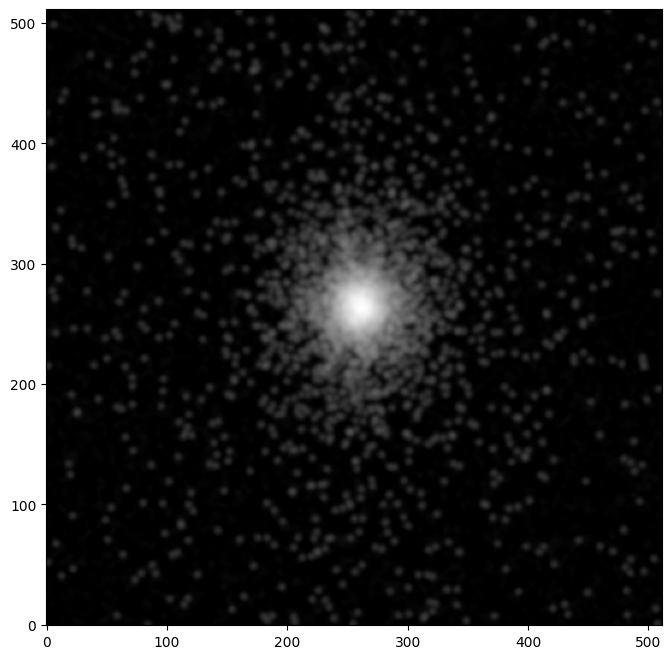

In [9]:
dens_save(part_list)

In [10]:
from PIL import Image
import os

if not os.path.exists('Figure'):
    os.makedirs('Figure', exist_ok=True)

folder_path = './dens'
gif_filename = './Figure/dens.gif'
images = [img for img in os.listdir(folder_path) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split('.')[0]))
frames = [Image.open(os.path.join(folder_path, img)) for img in images]
frames[0].save(gif_filename, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, 
               loop=0) 